In [2]:
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import cv2
from PIL import ImageEnhance
from utils import mask2yolo,make_pic
from tqdm import tqdm
mainpath = "./datasets/"
bg_path = "bg/"
fg_path = "fg_2/"
masks_path = "masks/"
fgs = os.listdir(mainpath+fg_path)
bgs = os.listdir(mainpath+bg_path)
masks = os.listdir(mainpath+masks_path)

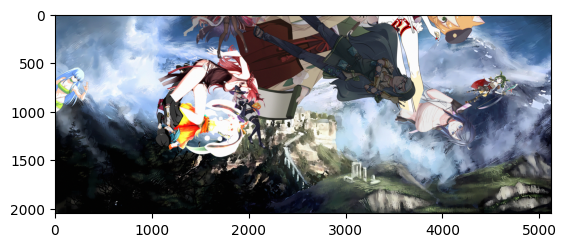

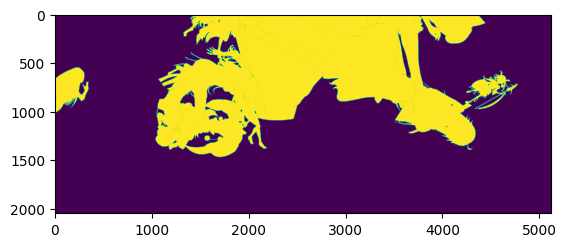

min_mask_size:69345.6
102996.5
3172527.5


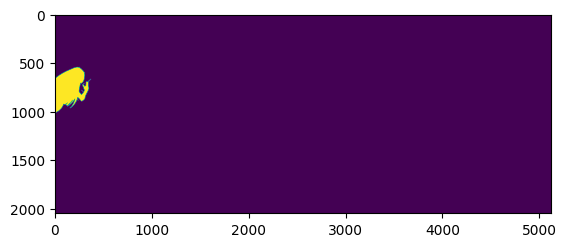

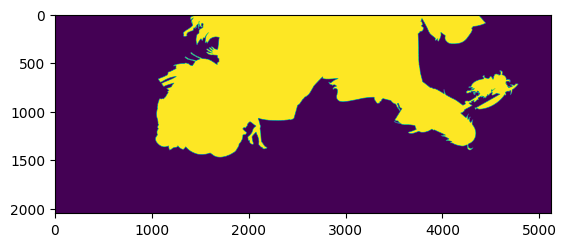

In [4]:
k = np.random.randint(len(fgs))

test_fg_list = [mainpath+fg_path+fg for fg in fgs[k:k+12]]
test_bg = mainpath+bg_path+bgs[810]
test_mask_list = [mainpath+masks_path+mask for mask in masks[k:k+12]]
mixed_pic,mixed_mask, mask_sizes = make_pic(test_fg_list,test_bg,test_mask_list)
# 打印出来看看
plt.imshow(mixed_pic)
plt.show()
mixed_mask = np.array(mixed_mask)
plt.imshow(mixed_mask)
plt.show()
yolo, mas, poligons = mask2yolo(mixed_mask,mask_sizes,show=True)
plt.imshow(mas)
for i in poligons:
    zeros = np.zeros(mixed_pic.size[::-1], np.uint8)
    cv2.fillPoly(zeros, [np.array(i).reshape(-1, 2)], (255, 255, 255))
    plt.imshow(zeros)
    plt.show()

In [5]:
# 为每个fg都生成一个yolo的
# 生成的yolo格式的mask保存在./datasets/masks_yolo/下
# 生成的叠加后的图片保存在./datasets/mixed_pic/下
# 改成tqdm的形式，可以看到进度条
subpath = "out2/"
if not os.path.exists(mainpath+"val2/"):
    os.mkdir(mainpath+"val2/")
if not os.path.exists(mainpath+"val/"):
    os.mkdir(mainpath+"val/")
if not  os.path.exists(mainpath+"mixed_mask/"):
    os.mkdir(mainpath+"mixed_mask/")

max_target_num = 8
pic_num = 400
for n in tqdm(range(pic_num), desc='Processing images'):
    target_num = np.random.randint(1,max_target_num)
    choice = np.random.choice(len(fgs),target_num)
    fg = []
    mask = []
    for i in choice:
        fg.append(fgs[i])
        mask.append(masks[i])
    bg_cur = bgs[np.random.randint(0,len(bgs))]
    fg_list = [mainpath+fg_path+i for i in fg]
    bg = mainpath+bg_path+bg_cur
    mask_list = [mainpath+masks_path+i for i in mask]
    mixed_pic, mixed_mask, mask_sizes = make_pic(fg_list, bg, mask_list)
    filename = ""
    for i in fg:
        filename += i[:-4]+"_"
    random_name = np.random.randint(0,100000)
    mixed_pic.save(mainpath+"val2/"+filename+"_"+bg_cur[:-4]+str(random_name)+".jpg")
    #mixed_mask.save(mainpath+"mixed_mask/"+filename+"_"+bg_cur[:-4]+".jpg")
    yolo = mask2yolo(mixed_mask, mask_sizes, show=False)
    with open(mainpath+"val2/"+filename+"_"+bg_cur[:-4]+str(random_name)+".txt","w") as f:
        f.write(yolo[0])
    

Processing images:   0%|          | 1/400 [00:01<12:25,  1.87s/it]

min_mask_size:135683.12549019608
1184221.5
414889.5


Processing images:   0%|          | 2/400 [00:02<08:44,  1.32s/it]

min_mask_size:181632.32156862746
380929.0


Processing images:   1%|          | 3/400 [00:03<07:25,  1.12s/it]

min_mask_size:746483.0078431373
750036.0


Processing images:   1%|          | 4/400 [00:05<09:51,  1.49s/it]

min_mask_size:124183.78823529412
202201.0
1054428.0


Processing images:   1%|▏         | 5/400 [00:06<07:19,  1.11s/it]

min_mask_size:70253.54509803922
79997.5


Processing images:   2%|▏         | 6/400 [00:07<08:23,  1.28s/it]

min_mask_size:93096.30980392157
256481.0
439285.0
214454.0


Processing images:   2%|▏         | 7/400 [00:10<10:23,  1.59s/it]

min_mask_size:40416.18431372549
41268.5
1994206.5


Processing images:   2%|▏         | 8/400 [00:11<09:51,  1.51s/it]

min_mask_size:78958.99607843137
421965.5


Processing images:   2%|▏         | 9/400 [00:12<09:29,  1.46s/it]

min_mask_size:94802.94901960784
315089.5
206581.0
692214.0


Processing images:   2%|▎         | 10/400 [00:14<10:33,  1.62s/it]

min_mask_size:41855.25490196078
44679.0
1211792.5


Processing images:   3%|▎         | 11/400 [00:15<09:13,  1.42s/it]

min_mask_size:23844.949019607844
114366.5
23950.0


Processing images:   3%|▎         | 12/400 [00:17<10:23,  1.61s/it]

min_mask_size:27449.976470588233
31720.5
319738.0


Processing images:   3%|▎         | 13/400 [00:18<09:44,  1.51s/it]

min_mask_size:72430.21176470588
427077.0


Processing images:   4%|▎         | 14/400 [00:19<08:15,  1.28s/it]

min_mask_size:163236.5137254902
171748.5


Processing images:   4%|▍         | 15/400 [00:20<06:46,  1.06s/it]

min_mask_size:204723.45098039217
216935.0


Processing images:   4%|▍         | 16/400 [00:20<06:00,  1.07it/s]

min_mask_size:125352.2
136682.0


Processing images:   4%|▍         | 17/400 [00:23<08:57,  1.40s/it]

min_mask_size:78061.37254901961
82127.5
1079635.5


Processing images:   4%|▍         | 18/400 [00:25<10:53,  1.71s/it]

min_mask_size:112609.47843137255
2100957.0


Processing images:   5%|▍         | 19/400 [00:28<12:53,  2.03s/it]

min_mask_size:31435.352941176472
1234023.0


Processing images:   5%|▌         | 20/400 [00:29<10:43,  1.69s/it]

min_mask_size:260576.6431372549
467046.5


Processing images:   5%|▌         | 21/400 [00:32<13:18,  2.11s/it]

min_mask_size:171223.8862745098
2198065.5


Processing images:   6%|▌         | 22/400 [00:33<11:11,  1.78s/it]

min_mask_size:37766.34901960784
483212.0
38012.0


Processing images:   6%|▌         | 23/400 [00:35<11:39,  1.86s/it]

min_mask_size:52889.05882352941
54089.0
1227188.0


Processing images:   6%|▌         | 24/400 [00:37<11:12,  1.79s/it]

min_mask_size:60518.22745098039
716632.5


Processing images:   6%|▋         | 25/400 [00:37<08:27,  1.35s/it]

min_mask_size:312986.03921568627
339001.0


Processing images:   6%|▋         | 26/400 [00:39<09:37,  1.54s/it]

min_mask_size:6291.733333333334
77188.0
586998.0
497187.5


Processing images:   7%|▋         | 27/400 [00:40<08:17,  1.33s/it]

min_mask_size:48574.5568627451
49518.0
575235.0


Processing images:   7%|▋         | 28/400 [00:41<07:05,  1.14s/it]

min_mask_size:278709.03921568627
305332.5


Processing images:   7%|▋         | 29/400 [00:42<08:12,  1.33s/it]

min_mask_size:35183.51372549019
156852.5
969744.0


Processing images:   8%|▊         | 30/400 [00:45<10:39,  1.73s/it]

min_mask_size:132018.44705882354
223724.5
141033.5
1225093.5


Processing images:   8%|▊         | 31/400 [00:46<09:26,  1.53s/it]

min_mask_size:86800.02352941176
81721.0
358745.5


Processing images:   8%|▊         | 32/400 [00:47<07:34,  1.24s/it]

min_mask_size:91968.28235294118
94871.5


Processing images:   8%|▊         | 33/400 [00:48<07:37,  1.25s/it]

min_mask_size:338488.96078431373
568383.0


Processing images:   8%|▊         | 34/400 [00:50<08:34,  1.41s/it]

min_mask_size:3478.4039215686275
458857.5
707272.0


Processing images:   9%|▉         | 35/400 [00:51<07:49,  1.29s/it]

min_mask_size:68756.79607843138
71899.0
401791.0


Processing images:   9%|▉         | 36/400 [00:52<07:44,  1.28s/it]

min_mask_size:87298.19607843137
248291.0
767399.5


Processing images:   9%|▉         | 37/400 [00:53<06:42,  1.11s/it]

min_mask_size:146649.98039215687
159689.5


Processing images:  10%|▉         | 38/400 [00:54<07:06,  1.18s/it]

min_mask_size:52332.12549019608
51914.0
598011.0


Processing images:  10%|▉         | 39/400 [00:59<13:40,  2.27s/it]

min_mask_size:31136.101960784315
422081.0
434781.0
546557.5
77562.0
108410.5
76283.0
31569.5


Processing images:  10%|█         | 40/400 [00:59<10:07,  1.69s/it]

min_mask_size:57130.870588235295
58294.5


Processing images:  10%|█         | 41/400 [01:00<07:41,  1.29s/it]

min_mask_size:72230.86274509804
104781.0


Processing images:  10%|█         | 42/400 [01:02<09:49,  1.65s/it]

min_mask_size:118863.29803921569
321913.0
1385935.5


Processing images:  11%|█         | 43/400 [01:04<10:24,  1.75s/it]

min_mask_size:82860.65098039215
118186.0
1235822.5


Processing images:  11%|█         | 44/400 [01:05<08:42,  1.47s/it]

min_mask_size:292890.96078431373
311956.5


Processing images:  11%|█▏        | 45/400 [01:06<08:29,  1.44s/it]

min_mask_size:69530.66274509804
287174.5


Processing images:  12%|█▏        | 46/400 [01:07<06:58,  1.18s/it]

min_mask_size:256120.031372549
272887.5


Processing images:  12%|█▏        | 47/400 [01:09<09:37,  1.64s/it]

min_mask_size:44865.48627450981
120689.5
1621912.5


Processing images:  12%|█▏        | 48/400 [01:11<10:00,  1.71s/it]

min_mask_size:84030.38431372549
210329.0
299296.5
562916.5


Processing images:  12%|█▏        | 49/400 [01:13<10:06,  1.73s/it]

min_mask_size:40901.7568627451
41752.0
1172146.5


Processing images:  12%|█▎        | 50/400 [01:15<10:11,  1.75s/it]

min_mask_size:73244.74509803922
74471.5
982830.5


Processing images:  13%|█▎        | 51/400 [01:16<08:34,  1.47s/it]

min_mask_size:219236.4392156863


Processing images:  13%|█▎        | 52/400 [01:17<07:42,  1.33s/it]

min_mask_size:53301.57647058823
55191.5
171666.5


Processing images:  13%|█▎        | 53/400 [01:19<09:28,  1.64s/it]

min_mask_size:102256.47843137255
1652816.0


Processing images:  14%|█▎        | 54/400 [01:22<10:56,  1.90s/it]

min_mask_size:114698.0431372549
120545.0
2128609.5


Processing images:  14%|█▍        | 55/400 [01:24<11:37,  2.02s/it]

min_mask_size:72844.16862745098
1020374.5


Processing images:  14%|█▍        | 56/400 [01:25<09:27,  1.65s/it]

min_mask_size:236570.29411764705
240481.5


Processing images:  14%|█▍        | 57/400 [01:26<09:12,  1.61s/it]

min_mask_size:41881.623529411765
141913.5


Processing images:  14%|█▍        | 58/400 [01:28<09:42,  1.70s/it]

min_mask_size:20359.764705882353
64792.0
412479.5


Processing images:  15%|█▍        | 59/400 [01:31<10:53,  1.92s/it]

min_mask_size:41617.14117647059
160588.0
1350939.5


Processing images:  15%|█▌        | 60/400 [01:32<10:00,  1.77s/it]

min_mask_size:127540.58823529411
360075.0


Processing images:  15%|█▌        | 61/400 [01:35<11:43,  2.08s/it]

min_mask_size:24269.57254901961
27012.0
62637.0
461067.0
927062.5


Processing images:  16%|█▌        | 62/400 [01:38<13:04,  2.32s/it]

min_mask_size:307882.6431372549
1570508.5


Processing images:  16%|█▌        | 63/400 [01:39<11:22,  2.03s/it]

min_mask_size:131874.63921568627
133718.5
399736.0


Processing images:  16%|█▌        | 64/400 [01:41<12:05,  2.16s/it]

min_mask_size:135371.49411764706
1564122.0


Processing images:  16%|█▋        | 65/400 [01:44<12:29,  2.24s/it]

min_mask_size:173793.38823529411
183363.5
1120730.5


Processing images:  16%|█▋        | 66/400 [01:44<09:14,  1.66s/it]

min_mask_size:13493.30980392157
26736.5


Processing images:  17%|█▋        | 67/400 [01:46<09:44,  1.76s/it]

min_mask_size:113882.41176470589
136344.5
1012367.0
894484.5


Processing images:  17%|█▋        | 68/400 [01:47<07:44,  1.40s/it]

min_mask_size:179774.42745098038
185984.5


Processing images:  17%|█▋        | 69/400 [01:49<08:44,  1.59s/it]

min_mask_size:203123.53725490195
1076555.0


Processing images:  18%|█▊        | 70/400 [01:51<10:11,  1.85s/it]

min_mask_size:17365.10980392157
1207302.0


Processing images:  18%|█▊        | 71/400 [01:52<08:31,  1.55s/it]

min_mask_size:23567.149019607845
218032.5


Processing images:  18%|█▊        | 72/400 [01:53<07:25,  1.36s/it]

min_mask_size:245528.6980392157
249906.0


Processing images:  18%|█▊        | 73/400 [01:54<07:35,  1.39s/it]

min_mask_size:18626.72156862745
19160.0
999255.5


Processing images:  18%|█▊        | 74/400 [01:55<06:44,  1.24s/it]

min_mask_size:31374.27843137255
397339.0


Processing images:  19%|█▉        | 75/400 [01:57<07:25,  1.37s/it]

min_mask_size:13168.729411764705
80641.5
79518.0
13586.5
984065.5


Processing images:  19%|█▉        | 76/400 [01:59<08:51,  1.64s/it]

min_mask_size:53529.81176470588
342885.0
54887.5


Processing images:  19%|█▉        | 77/400 [02:02<09:57,  1.85s/it]

min_mask_size:27719.113725490195
706102.5


Processing images:  20%|█▉        | 78/400 [02:04<09:59,  1.86s/it]

min_mask_size:153390.2862745098
153454.5
1667777.0


Processing images:  20%|█▉        | 79/400 [02:04<08:06,  1.52s/it]

min_mask_size:370285.55294117646
373841.5


Processing images:  20%|██        | 80/400 [02:06<08:39,  1.62s/it]

min_mask_size:57571.79607843137
1086618.0


Processing images:  20%|██        | 81/400 [02:08<09:03,  1.70s/it]

min_mask_size:92363.80784313726
356117.0
199658.5
481750.0


Processing images:  20%|██        | 82/400 [02:08<06:50,  1.29s/it]

min_mask_size:175295.98823529412
194797.0


Processing images:  21%|██        | 83/400 [02:10<07:38,  1.45s/it]

min_mask_size:259410.0588235294
1009604.5


Processing images:  21%|██        | 84/400 [02:11<06:29,  1.23s/it]

min_mask_size:103957.32549019608
105461.0


Processing images:  21%|██▏       | 85/400 [02:12<06:28,  1.23s/it]

min_mask_size:132317.3725490196
134050.0


Processing images:  22%|██▏       | 86/400 [02:14<07:04,  1.35s/it]

min_mask_size:114777.5294117647
211407.0
1161738.5


Processing images:  22%|██▏       | 87/400 [02:15<06:45,  1.30s/it]

min_mask_size:236574.01960784313
569068.5


Processing images:  22%|██▏       | 88/400 [02:17<07:46,  1.50s/it]

min_mask_size:52221.12156862745
59691.0
825842.0
371324.0


Processing images:  22%|██▏       | 89/400 [02:18<07:11,  1.39s/it]

min_mask_size:69376.12549019608
69873.5
773066.0


Processing images:  22%|██▎       | 90/400 [02:19<06:03,  1.17s/it]

min_mask_size:182860.19215686276
189787.5


Processing images:  23%|██▎       | 91/400 [02:19<04:45,  1.08it/s]

min_mask_size:131788.8705882353
133937.5


Processing images:  23%|██▎       | 92/400 [02:21<06:59,  1.36s/it]

min_mask_size:71798.5725490196
106598.0
277352.0
1062381.0


Processing images:  23%|██▎       | 93/400 [02:23<07:30,  1.47s/it]

min_mask_size:46028.86274509804
347620.0
1297184.0
47546.0


Processing images:  24%|██▎       | 94/400 [02:24<06:53,  1.35s/it]

min_mask_size:216546.74901960784
221402.0


Processing images:  24%|██▍       | 95/400 [02:25<06:35,  1.30s/it]

min_mask_size:140932.93725490195
397099.0


Processing images:  24%|██▍       | 96/400 [02:28<08:32,  1.69s/it]

min_mask_size:54360.33725490196
55610.0
89430.0
1282888.0


Processing images:  24%|██▍       | 97/400 [02:29<07:13,  1.43s/it]

min_mask_size:122051.41568627451
124013.5
361935.5


Processing images:  24%|██▍       | 98/400 [02:30<06:15,  1.24s/it]

min_mask_size:9830.69019607843
285132.0


Processing images:  25%|██▍       | 99/400 [02:33<09:48,  1.96s/it]

min_mask_size:110432.94509803921
1852422.0


Processing images:  25%|██▌       | 100/400 [02:35<09:07,  1.82s/it]

min_mask_size:154335.71764705883
1079763.0


Processing images:  25%|██▌       | 101/400 [02:36<07:53,  1.59s/it]

min_mask_size:25207.32549019608
93637.5
550669.5


Processing images:  26%|██▌       | 102/400 [02:37<06:45,  1.36s/it]

min_mask_size:84847.09019607842
93054.5
294401.5
104474.0


Processing images:  26%|██▌       | 103/400 [02:39<08:38,  1.74s/it]

min_mask_size:198603.65490196078
1304139.5


Processing images:  26%|██▌       | 104/400 [02:40<07:17,  1.48s/it]

min_mask_size:86414.69803921568
87425.0


Processing images:  26%|██▋       | 105/400 [02:42<07:48,  1.59s/it]

min_mask_size:16344.462745098039
134627.5
17318.5
1126538.0


Processing images:  26%|██▋       | 106/400 [02:44<07:44,  1.58s/it]

min_mask_size:69636.5137254902
918131.0
593599.0


Processing images:  27%|██▋       | 107/400 [02:44<06:38,  1.36s/it]

min_mask_size:279252.5607843137
294708.5


Processing images:  27%|██▋       | 108/400 [02:47<08:10,  1.68s/it]

min_mask_size:70713.70588235294
79045.5
102523.0
460956.5


Processing images:  27%|██▋       | 109/400 [02:48<06:47,  1.40s/it]

min_mask_size:413559.96470588236
439755.5


Processing images:  28%|██▊       | 110/400 [02:49<07:06,  1.47s/it]

min_mask_size:180766.49411764706
567700.0
181200.0


Processing images:  28%|██▊       | 111/400 [02:51<07:31,  1.56s/it]

min_mask_size:177158.54901960783
1615783.0


Processing images:  28%|██▊       | 112/400 [02:53<07:42,  1.61s/it]

min_mask_size:100461.78823529412
766013.5


Processing images:  28%|██▊       | 113/400 [02:53<06:14,  1.31s/it]

min_mask_size:192108.71764705883
195626.0


Processing images:  28%|██▊       | 114/400 [02:55<07:08,  1.50s/it]

min_mask_size:224037.76862745098
1713087.5


Processing images:  29%|██▉       | 115/400 [02:57<07:26,  1.57s/it]

min_mask_size:42985.22745098039
80047.0
43496.0
868593.5
389049.5


Processing images:  29%|██▉       | 116/400 [03:00<09:33,  2.02s/it]

min_mask_size:64172.933333333334
160744.5
102628.5
325054.0
65246.0
1007175.5


Processing images:  29%|██▉       | 117/400 [03:02<08:50,  1.87s/it]

min_mask_size:95917.97254901961
1511909.5


Processing images:  30%|██▉       | 118/400 [03:04<08:58,  1.91s/it]

min_mask_size:73787.37647058823
1982700.5


Processing images:  30%|██▉       | 119/400 [03:06<09:37,  2.06s/it]

min_mask_size:15396.290196078431
16103.5
506392.5
636905.0


Processing images:  30%|███       | 120/400 [03:06<07:19,  1.57s/it]

min_mask_size:8654.258823529412
239583.0


Processing images:  30%|███       | 121/400 [03:09<08:38,  1.86s/it]

min_mask_size:151358.4862745098
171815.5
1889663.0


Processing images:  30%|███       | 122/400 [03:10<07:35,  1.64s/it]

min_mask_size:264962.1725490196
1000892.0


Processing images:  31%|███       | 123/400 [03:12<08:01,  1.74s/it]

min_mask_size:13161.058823529413
13508.0
145664.0
1068025.5


Processing images:  31%|███       | 124/400 [03:14<07:51,  1.71s/it]

min_mask_size:73498.74901960784
386034.0
1256133.0


Processing images:  31%|███▏      | 125/400 [03:14<06:34,  1.44s/it]

min_mask_size:157883.33333333334
295660.0


Processing images:  32%|███▏      | 126/400 [03:15<05:41,  1.24s/it]

min_mask_size:35576.419607843134
229191.0


Processing images:  32%|███▏      | 127/400 [03:17<06:05,  1.34s/it]

min_mask_size:147564.93725490195
148639.5
1170229.0


Processing images:  32%|███▏      | 128/400 [03:17<05:10,  1.14s/it]

min_mask_size:123011.54509803922
263345.5


Processing images:  32%|███▏      | 129/400 [03:18<04:51,  1.08s/it]

min_mask_size:69772.09803921569
71855.5
198395.5


Processing images:  32%|███▎      | 130/400 [03:19<04:42,  1.05s/it]

min_mask_size:138084.9137254902
205603.5


Processing images:  33%|███▎      | 131/400 [03:21<05:01,  1.12s/it]

min_mask_size:49244.40392156863
371820.0


Processing images:  33%|███▎      | 132/400 [03:24<08:33,  1.92s/it]

min_mask_size:272310.7294117647
597429.5
833405.0


Processing images:  33%|███▎      | 133/400 [03:26<08:05,  1.82s/it]

min_mask_size:37015.490196078434
102467.5
48397.5
249250.0
335779.0


Processing images:  34%|███▎      | 134/400 [03:27<07:24,  1.67s/it]

min_mask_size:37298.85490196078
557257.5


Processing images:  34%|███▍      | 135/400 [03:28<05:45,  1.30s/it]

min_mask_size:298437.0862745098
300870.0


Processing images:  34%|███▍      | 136/400 [03:29<05:52,  1.33s/it]

min_mask_size:25961.039215686276
221923.0


Processing images:  34%|███▍      | 137/400 [03:30<05:06,  1.17s/it]

min_mask_size:111743.92549019608
561040.5


Processing images:  34%|███▍      | 138/400 [03:32<06:41,  1.53s/it]

min_mask_size:59162.68235294118
61934.0
465457.5


Processing images:  35%|███▍      | 139/400 [03:33<05:55,  1.36s/it]

min_mask_size:291559.6823529412
292965.5


Processing images:  35%|███▌      | 140/400 [03:36<08:06,  1.87s/it]

min_mask_size:16795.254901960783
1996576.5


Processing images:  35%|███▌      | 141/400 [03:37<06:18,  1.46s/it]

min_mask_size:104337.94117647059
253437.5


Processing images:  36%|███▌      | 142/400 [03:38<06:19,  1.47s/it]

min_mask_size:73654.4
75225.5
504375.5


Processing images:  36%|███▌      | 143/400 [03:40<06:06,  1.43s/it]

min_mask_size:32856.90588235294
33479.5
508558.0
59886.0


Processing images:  36%|███▌      | 144/400 [03:43<07:56,  1.86s/it]

min_mask_size:123068.9137254902
186295.0
3108583.5


Processing images:  36%|███▋      | 145/400 [03:44<07:18,  1.72s/it]

min_mask_size:24275.470588235294
139156.0


Processing images:  36%|███▋      | 146/400 [03:45<06:44,  1.59s/it]

min_mask_size:36831.325490196075
402808.0


Processing images:  37%|███▋      | 147/400 [03:48<07:42,  1.83s/it]

min_mask_size:108544.54901960785
122246.0
1498843.5


Processing images:  37%|███▋      | 148/400 [03:49<06:46,  1.61s/it]

min_mask_size:48917.541176470586
188688.0
709622.0


Processing images:  37%|███▋      | 149/400 [03:51<07:44,  1.85s/it]

min_mask_size:40062.05098039216
2347521.0
87312.0


Processing images:  38%|███▊      | 150/400 [03:53<08:03,  1.93s/it]

min_mask_size:64699.78039215686
66454.0
117931.5
1096323.0


Processing images:  38%|███▊      | 151/400 [03:54<06:43,  1.62s/it]

min_mask_size:121281.89411764705
257851.0


Processing images:  38%|███▊      | 152/400 [03:56<06:29,  1.57s/it]

min_mask_size:120012.83529411764
121091.5
564325.5


Processing images:  38%|███▊      | 153/400 [03:57<06:15,  1.52s/it]

min_mask_size:18999.729411764707
557870.5


Processing images:  38%|███▊      | 154/400 [03:57<04:50,  1.18s/it]

min_mask_size:112294.14901960784
113695.5


Processing images:  39%|███▉      | 155/400 [03:59<04:48,  1.18s/it]

min_mask_size:105008.73725490196
490154.0


Processing images:  39%|███▉      | 156/400 [04:01<05:59,  1.47s/it]

min_mask_size:100724.18823529412
1063485.0


Processing images:  39%|███▉      | 157/400 [04:02<06:04,  1.50s/it]

min_mask_size:621738.662745098
973265.5


Processing images:  40%|███▉      | 158/400 [04:04<05:45,  1.43s/it]

min_mask_size:606513.4549019608
634221.5


Processing images:  40%|███▉      | 159/400 [04:06<06:23,  1.59s/it]

min_mask_size:185701.5137254902
1702829.0


Processing images:  40%|████      | 160/400 [04:08<07:42,  1.93s/it]

min_mask_size:18515.019607843136
108809.5
18663.5
141112.0
238087.0


Processing images:  40%|████      | 161/400 [04:10<07:11,  1.81s/it]

min_mask_size:74167.58823529411
586424.0


Processing images:  40%|████      | 162/400 [04:11<06:49,  1.72s/it]

min_mask_size:183295.72156862746
198780.5
486858.5


Processing images:  41%|████      | 163/400 [04:13<07:20,  1.86s/it]

min_mask_size:95107.53333333334
668893.5


Processing images:  41%|████      | 164/400 [04:15<06:45,  1.72s/it]

min_mask_size:42204.74117647059
43576.5
740850.5


Processing images:  41%|████▏     | 165/400 [04:17<06:56,  1.77s/it]

min_mask_size:77543.13725490196
504467.5


Processing images:  42%|████▏     | 166/400 [04:18<06:22,  1.63s/it]

min_mask_size:16822.082352941175
456881.0
355018.5


Processing images:  42%|████▏     | 167/400 [04:19<05:05,  1.31s/it]

min_mask_size:116163.56078431373
121268.5


Processing images:  42%|████▏     | 168/400 [04:19<03:54,  1.01s/it]

min_mask_size:99286.33333333333
324977.0


Processing images:  42%|████▏     | 169/400 [04:21<04:54,  1.28s/it]

min_mask_size:51255.74509803922
546942.0


Processing images:  42%|████▎     | 170/400 [04:25<07:48,  2.04s/it]

min_mask_size:148042.05098039214
233651.0
1654103.5


Processing images:  43%|████▎     | 171/400 [04:26<07:08,  1.87s/it]

min_mask_size:43840.80392156863
143005.5
45866.0
663944.5


Processing images:  43%|████▎     | 172/400 [04:27<06:26,  1.70s/it]

min_mask_size:121240.6705882353
525090.0


Processing images:  43%|████▎     | 173/400 [04:28<05:35,  1.48s/it]

min_mask_size:112278.71372549019
115162.5
314672.5


Processing images:  44%|████▎     | 174/400 [04:30<05:15,  1.40s/it]

min_mask_size:63639.38039215686
66256.5
696801.5


Processing images:  44%|████▍     | 175/400 [04:32<05:58,  1.59s/it]

min_mask_size:118599.65882352942
243052.5
1135984.5


Processing images:  44%|████▍     | 176/400 [04:34<06:27,  1.73s/it]

min_mask_size:61031.18823529412
62532.0
206696.0
1194478.5


Processing images:  44%|████▍     | 177/400 [04:36<06:46,  1.82s/it]

min_mask_size:37885.686274509804
1020590.5


Processing images:  44%|████▍     | 178/400 [04:37<06:31,  1.76s/it]

min_mask_size:42337.25490196078
44213.0
1059133.5
65662.5


Processing images:  45%|████▍     | 179/400 [04:40<07:02,  1.91s/it]

min_mask_size:47818.98431372549
109490.5
1806047.0


Processing images:  45%|████▌     | 180/400 [04:42<07:26,  2.03s/it]

min_mask_size:83582.20784313725
1158730.5


Processing images:  45%|████▌     | 181/400 [04:44<07:56,  2.18s/it]

min_mask_size:37204.04705882353
693272.0


Processing images:  46%|████▌     | 182/400 [04:45<06:17,  1.73s/it]

min_mask_size:59291.1137254902
87315.5


Processing images:  46%|████▌     | 183/400 [04:47<06:06,  1.69s/it]

min_mask_size:45769.67843137255
197248.0
496561.0


Processing images:  46%|████▌     | 184/400 [04:49<07:07,  1.98s/it]

min_mask_size:68486.1294117647
1592455.0


Processing images:  46%|████▋     | 185/400 [04:52<07:24,  2.07s/it]

min_mask_size:39141.53725490196
269068.0
1664588.5


Processing images:  46%|████▋     | 186/400 [04:53<06:11,  1.73s/it]

min_mask_size:15776.93725490196
303782.0


Processing images:  47%|████▋     | 187/400 [04:55<06:19,  1.78s/it]

min_mask_size:32481.86274509804
32991.0
113556.5
653215.5


Processing images:  47%|████▋     | 188/400 [04:56<06:20,  1.79s/it]

min_mask_size:169970.85882352942
969514.5


Processing images:  47%|████▋     | 189/400 [04:58<05:38,  1.60s/it]

min_mask_size:233282.6745098039
601250.5


Processing images:  48%|████▊     | 190/400 [04:59<05:19,  1.52s/it]

min_mask_size:319460.09411764704
603931.5
327257.5


Processing images:  48%|████▊     | 191/400 [05:02<06:35,  1.89s/it]

min_mask_size:28444.141176470588
269619.0
923212.5
42478.0


Processing images:  48%|████▊     | 192/400 [05:02<05:25,  1.56s/it]

min_mask_size:101269.4274509804
107786.0


Processing images:  48%|████▊     | 193/400 [05:04<05:50,  1.69s/it]

min_mask_size:134138.65490196078
151232.0
818438.0
621689.0


Processing images:  48%|████▊     | 194/400 [05:06<05:39,  1.65s/it]

min_mask_size:7520.058823529412
825292.0


Processing images:  49%|████▉     | 195/400 [05:08<05:40,  1.66s/it]

min_mask_size:50125.45490196079
50598.0
1043136.5


Processing images:  49%|████▉     | 196/400 [05:09<05:03,  1.49s/it]

min_mask_size:37991.129411764705
39174.0
760602.5


Processing images:  49%|████▉     | 197/400 [05:10<05:01,  1.49s/it]

min_mask_size:42458.74901960784
45927.5
800275.0


Processing images:  50%|████▉     | 198/400 [05:12<05:01,  1.49s/it]

min_mask_size:47462.97254901961
990791.5


Processing images:  50%|████▉     | 199/400 [05:13<04:31,  1.35s/it]

min_mask_size:221976.18039215685
227478.5


Processing images:  50%|█████     | 200/400 [05:14<04:30,  1.35s/it]

min_mask_size:104361.18823529412
102856.5
539263.5


Processing images:  50%|█████     | 201/400 [05:15<03:58,  1.20s/it]

min_mask_size:188934.87843137255
180720.5


Processing images:  50%|█████     | 202/400 [05:17<04:54,  1.49s/it]

min_mask_size:89331.02352941176
970346.5


Processing images:  51%|█████     | 203/400 [05:19<05:26,  1.66s/it]

min_mask_size:205824.68235294116
998045.5


Processing images:  51%|█████     | 204/400 [05:20<04:35,  1.41s/it]

min_mask_size:35651.00784313725
36320.5
361615.5


Processing images:  51%|█████▏    | 205/400 [05:21<03:53,  1.20s/it]

min_mask_size:163586.16862745097
166828.5


Processing images:  52%|█████▏    | 206/400 [05:22<04:04,  1.26s/it]

min_mask_size:118485.40784313726
125603.0
1268516.5


Processing images:  52%|█████▏    | 207/400 [05:25<05:39,  1.76s/it]

min_mask_size:52173.43137254902
1394478.0


Processing images:  52%|█████▏    | 208/400 [05:27<05:41,  1.78s/it]

min_mask_size:62281.76470588235
432841.0


Processing images:  52%|█████▏    | 209/400 [05:28<04:57,  1.56s/it]

min_mask_size:49717.7294117647
648311.5
51237.0


Processing images:  52%|█████▎    | 210/400 [05:30<05:18,  1.68s/it]

min_mask_size:42008.05882352941
560934.0
42422.0
801197.5


Processing images:  53%|█████▎    | 211/400 [05:31<04:48,  1.53s/it]

min_mask_size:591994.9764705882
596867.0


Processing images:  53%|█████▎    | 212/400 [05:32<04:16,  1.37s/it]

min_mask_size:256736.3137254902
490393.5


Processing images:  53%|█████▎    | 213/400 [05:33<04:08,  1.33s/it]

min_mask_size:52457.60784313725
268120.5


Processing images:  54%|█████▎    | 214/400 [05:37<06:22,  2.06s/it]

min_mask_size:169732.89411764705
179281.5
229613.5
224076.0
1180772.0
877290.5


Processing images:  54%|█████▍    | 215/400 [05:38<05:46,  1.87s/it]

min_mask_size:454198.53725490195
441298.5


Processing images:  54%|█████▍    | 216/400 [05:39<04:50,  1.58s/it]

min_mask_size:34625.356862745095
223466.0
66702.5
41640.5


Processing images:  54%|█████▍    | 217/400 [05:41<04:39,  1.53s/it]

min_mask_size:55417.63921568627
697216.5


Processing images:  55%|█████▍    | 218/400 [05:41<03:51,  1.27s/it]

min_mask_size:373675.1215686274
381687.5


Processing images:  55%|█████▍    | 219/400 [05:44<05:13,  1.73s/it]

min_mask_size:58239.345098039215
1193059.0


Processing images:  55%|█████▌    | 220/400 [05:46<04:55,  1.64s/it]

min_mask_size:69277.23137254902
324476.0


Processing images:  55%|█████▌    | 221/400 [05:47<04:51,  1.63s/it]

min_mask_size:61504.60784313725
102512.5
700052.0
62848.0


Processing images:  56%|█████▌    | 222/400 [05:48<04:26,  1.50s/it]

min_mask_size:240081.8862745098
735868.0
241443.0


Processing images:  56%|█████▌    | 223/400 [05:52<05:52,  1.99s/it]

min_mask_size:159397.9176470588
264432.5
2061229.5


Processing images:  56%|█████▌    | 224/400 [05:53<05:04,  1.73s/it]

min_mask_size:35556.49803921569
37214.5
533770.5


Processing images:  56%|█████▋    | 225/400 [05:54<04:36,  1.58s/it]

min_mask_size:591690.725490196
611397.5


Processing images:  56%|█████▋    | 226/400 [05:56<05:11,  1.79s/it]

min_mask_size:81577.97647058824
647521.5


Processing images:  57%|█████▋    | 227/400 [05:59<05:43,  1.99s/it]

min_mask_size:158056.3568627451
1187027.5


Processing images:  57%|█████▋    | 228/400 [06:01<05:47,  2.02s/it]

min_mask_size:189557.78039215686
201226.5
575072.0


Processing images:  57%|█████▋    | 229/400 [06:04<06:52,  2.41s/it]

min_mask_size:26461.376470588235
152878.0
2458147.0


Processing images:  57%|█████▊    | 230/400 [06:05<05:11,  1.83s/it]

min_mask_size:252555.8862745098
410634.5


Processing images:  58%|█████▊    | 231/400 [06:07<06:02,  2.14s/it]

min_mask_size:150773.03921568627
2064852.5


Processing images:  58%|█████▊    | 232/400 [06:08<04:54,  1.75s/it]

min_mask_size:100250.36862745098
102912.0
105422.5


Processing images:  58%|█████▊    | 233/400 [06:10<05:14,  1.88s/it]

min_mask_size:11677.145098039216
39136.0
514385.0


Processing images:  58%|█████▊    | 234/400 [06:11<04:26,  1.60s/it]

min_mask_size:221306.0156862745
233502.0


Processing images:  59%|█████▉    | 235/400 [06:13<04:42,  1.71s/it]

min_mask_size:29021.333333333332
75803.5
1312799.0


Processing images:  59%|█████▉    | 236/400 [06:15<04:21,  1.59s/it]

min_mask_size:68058.12156862745
80970.0
72001.5
156987.5


Processing images:  59%|█████▉    | 237/400 [06:15<03:35,  1.32s/it]

min_mask_size:80256.63921568627
80169.0


Processing images:  60%|█████▉    | 238/400 [06:16<03:17,  1.22s/it]

min_mask_size:149254.96078431373
150473.5
274984.5
395140.0


Processing images:  60%|█████▉    | 239/400 [06:18<03:51,  1.44s/it]

min_mask_size:11322.474509803922
1046041.0


Processing images:  60%|██████    | 240/400 [06:20<04:24,  1.65s/it]

min_mask_size:90721.90196078431
767553.5


Processing images:  60%|██████    | 241/400 [06:22<04:02,  1.53s/it]

min_mask_size:127340.67450980392
643664.0


Processing images:  60%|██████    | 242/400 [06:23<03:28,  1.32s/it]

min_mask_size:123973.2431372549
256481.5


Processing images:  61%|██████    | 243/400 [06:23<02:52,  1.10s/it]

min_mask_size:132413.86274509804
337379.0


Processing images:  61%|██████    | 244/400 [06:25<03:08,  1.21s/it]

min_mask_size:151478.25098039216
156414.0
995226.5


Processing images:  61%|██████▏   | 245/400 [06:25<02:26,  1.05it/s]

min_mask_size:75651.8431372549
77168.5


Processing images:  62%|██████▏   | 246/400 [06:27<02:58,  1.16s/it]

min_mask_size:68921.27058823529
112510.5
483466.0


Processing images:  62%|██████▏   | 247/400 [06:27<02:24,  1.06it/s]

min_mask_size:161209.0823529412
162761.0


Processing images:  62%|██████▏   | 248/400 [06:28<02:45,  1.09s/it]

min_mask_size:47147.603921568625
1135367.0


Processing images:  62%|██████▏   | 249/400 [06:30<03:11,  1.27s/it]

min_mask_size:84618.33725490196
139014.0
900447.0
302488.0


Processing images:  62%|██████▎   | 250/400 [06:31<02:39,  1.06s/it]

min_mask_size:393971.89019607846
739467.0


Processing images:  63%|██████▎   | 251/400 [06:33<03:16,  1.32s/it]

min_mask_size:69362.90588235293
75845.5
994866.0
292572.0


Processing images:  63%|██████▎   | 252/400 [06:34<03:23,  1.38s/it]

min_mask_size:19122.86274509804
19346.5
767799.0
126568.0
82572.5


Processing images:  63%|██████▎   | 253/400 [06:37<04:18,  1.76s/it]

min_mask_size:97269.29803921569
1030811.0
638204.0


Processing images:  64%|██████▎   | 254/400 [06:39<04:31,  1.86s/it]

min_mask_size:48830.345098039215
76048.0
1427974.5


Processing images:  64%|██████▍   | 255/400 [06:40<04:15,  1.76s/it]

min_mask_size:29480.12549019608
47642.5
671399.0


Processing images:  64%|██████▍   | 256/400 [06:41<03:26,  1.43s/it]

min_mask_size:236253.89411764705
261911.0
264537.5


Processing images:  64%|██████▍   | 257/400 [06:43<03:46,  1.58s/it]

min_mask_size:50101.51372549019
214334.5
50552.5
858390.5


Processing images:  64%|██████▍   | 258/400 [06:45<03:49,  1.62s/it]

min_mask_size:60477.53725490196
74797.0
347431.5
475981.0
63885.5
339380.0


Processing images:  65%|██████▍   | 259/400 [06:48<04:49,  2.05s/it]

min_mask_size:137101.54901960783
140715.5
1641920.0


Processing images:  65%|██████▌   | 260/400 [06:49<04:23,  1.88s/it]

min_mask_size:388616.9411764706
653097.5


Processing images:  65%|██████▌   | 261/400 [06:50<03:15,  1.40s/it]

min_mask_size:219424.30980392155
227162.5


Processing images:  66%|██████▌   | 262/400 [06:51<03:36,  1.57s/it]

min_mask_size:34900.54509803921
116825.5
1491787.0


Processing images:  66%|██████▌   | 263/400 [06:54<04:07,  1.80s/it]

min_mask_size:254566.72156862746
1622287.0


Processing images:  66%|██████▌   | 264/400 [06:54<03:15,  1.44s/it]

min_mask_size:60046.333333333336
365521.5


Processing images:  66%|██████▋   | 265/400 [06:56<03:16,  1.46s/it]

min_mask_size:187464.34509803922
851528.0


Processing images:  66%|██████▋   | 266/400 [06:59<04:10,  1.87s/it]

min_mask_size:96577.85490196079
1502109.0


Processing images:  67%|██████▋   | 267/400 [07:00<03:36,  1.63s/it]

min_mask_size:257720.37647058823
259423.0
417003.5


Processing images:  67%|██████▋   | 268/400 [07:01<03:17,  1.50s/it]

min_mask_size:154695.63529411764
977608.0


Processing images:  67%|██████▋   | 269/400 [07:04<04:02,  1.85s/it]

min_mask_size:31309.686274509804
33879.5
129825.0
71307.5
1249259.0


Processing images:  68%|██████▊   | 270/400 [07:06<04:29,  2.07s/it]

min_mask_size:44531.407843137255
122306.5
46032.5
1982838.0


Processing images:  68%|██████▊   | 271/400 [07:08<03:55,  1.83s/it]

min_mask_size:53623.603921568625
55052.5
309590.0


Processing images:  68%|██████▊   | 272/400 [07:09<03:28,  1.63s/it]

min_mask_size:46109.38431372549
425007.5


Processing images:  68%|██████▊   | 273/400 [07:10<02:57,  1.40s/it]

min_mask_size:244592.7568627451
247002.0


Processing images:  68%|██████▊   | 274/400 [07:11<03:11,  1.52s/it]

min_mask_size:68506.2156862745
983660.0


Processing images:  69%|██████▉   | 275/400 [07:12<02:52,  1.38s/it]

min_mask_size:40937.654901960785
366858.0
91233.0


Processing images:  69%|██████▉   | 276/400 [07:14<03:11,  1.55s/it]

min_mask_size:19720.258823529413
29935.0
83507.0
19974.0
855014.0


Processing images:  69%|██████▉   | 277/400 [07:15<02:51,  1.39s/it]

min_mask_size:35293.48235294117
51971.0
36013.0
377234.0


Processing images:  70%|██████▉   | 278/400 [07:17<03:05,  1.52s/it]

min_mask_size:28069.8
925065.5


Processing images:  70%|██████▉   | 279/400 [07:18<02:49,  1.40s/it]

min_mask_size:128756.33333333333
449212.5
139686.5


Processing images:  70%|███████   | 280/400 [07:22<03:53,  1.95s/it]

min_mask_size:28593.46274509804
29851.0
252356.0
193104.0
138423.0
371492.0
1048793.5


Processing images:  70%|███████   | 281/400 [07:23<03:17,  1.66s/it]

min_mask_size:63055.129411764705
71903.0
207694.0
175077.0


Processing images:  70%|███████   | 282/400 [07:24<03:08,  1.60s/it]

min_mask_size:203101.35294117648
359800.0


Processing images:  71%|███████   | 283/400 [07:25<02:48,  1.44s/it]

min_mask_size:86990.2431372549
90047.0
721414.0


Processing images:  71%|███████   | 284/400 [07:26<02:29,  1.29s/it]

min_mask_size:241656.54901960783
252174.0


Processing images:  71%|███████▏  | 285/400 [07:27<02:35,  1.35s/it]

min_mask_size:181045.43529411763
196601.5
1040442.5


Processing images:  72%|███████▏  | 286/400 [07:29<02:56,  1.55s/it]

min_mask_size:67579.0862745098
68518.0
1068794.5


Processing images:  72%|███████▏  | 287/400 [07:31<02:37,  1.39s/it]

min_mask_size:381794.85098039213
802418.0


Processing images:  72%|███████▏  | 288/400 [07:32<02:39,  1.43s/it]

min_mask_size:55686.407843137255
905538.0


Processing images:  72%|███████▏  | 289/400 [07:34<02:46,  1.50s/it]

min_mask_size:72757.32156862745
73797.0
90962.0
1255570.5


Processing images:  72%|███████▎  | 290/400 [07:37<03:40,  2.01s/it]

min_mask_size:99310.75294117647
1527309.5


Processing images:  73%|███████▎  | 291/400 [07:39<03:34,  1.97s/it]

min_mask_size:123638.02745098039
382506.5
192654.5


Processing images:  73%|███████▎  | 292/400 [07:40<03:02,  1.69s/it]

min_mask_size:374440.7843137255
800491.5


Processing images:  73%|███████▎  | 293/400 [07:41<02:50,  1.59s/it]

min_mask_size:99804.87843137255
106456.0
538467.5


Processing images:  74%|███████▎  | 294/400 [07:42<02:30,  1.42s/it]

min_mask_size:400100.63137254905
405621.5


Processing images:  74%|███████▍  | 295/400 [07:44<02:32,  1.45s/it]

min_mask_size:235693.76862745098
384421.5
645856.0


Processing images:  74%|███████▍  | 296/400 [07:45<02:29,  1.44s/it]

min_mask_size:31495.894117647058
32585.5
174801.5


Processing images:  74%|███████▍  | 297/400 [07:47<02:50,  1.66s/it]

min_mask_size:62927.84705882353
638075.5


Processing images:  74%|███████▍  | 298/400 [07:49<02:44,  1.61s/it]

min_mask_size:159005.3137254902
1144404.0


Processing images:  75%|███████▍  | 299/400 [07:50<02:41,  1.60s/it]

min_mask_size:124787.87843137255
999643.5


Processing images:  75%|███████▌  | 300/400 [07:52<02:33,  1.53s/it]

min_mask_size:80118.33725490196
546796.0


Processing images:  75%|███████▌  | 301/400 [07:53<02:30,  1.52s/it]

min_mask_size:123089.6
289523.0
562224.5


Processing images:  76%|███████▌  | 302/400 [07:55<02:41,  1.65s/it]

min_mask_size:47695.50196078431
48091.5
827815.5
404865.5


Processing images:  76%|███████▌  | 303/400 [07:57<02:51,  1.77s/it]

min_mask_size:157878.59215686275
250845.5
168239.0
793765.0


Processing images:  76%|███████▌  | 304/400 [08:00<03:14,  2.02s/it]

min_mask_size:30341.949019607844
32129.5
1688414.0


Processing images:  76%|███████▋  | 305/400 [08:02<03:09,  2.00s/it]

min_mask_size:60162.611764705885
390259.0


Processing images:  76%|███████▋  | 306/400 [08:05<03:27,  2.21s/it]

min_mask_size:238467.61960784314
1920991.0


Processing images:  77%|███████▋  | 307/400 [08:07<03:23,  2.19s/it]

min_mask_size:43588.129411764705
540517.0


Processing images:  77%|███████▋  | 308/400 [08:09<03:16,  2.13s/it]

min_mask_size:158281.93333333332
159912.5
1859064.0


Processing images:  77%|███████▋  | 309/400 [08:10<02:43,  1.79s/it]

min_mask_size:220956.92156862744
212689.0


Processing images:  78%|███████▊  | 310/400 [08:12<03:00,  2.01s/it]

min_mask_size:50448.180392156864
924479.0


Processing images:  78%|███████▊  | 311/400 [08:14<02:52,  1.94s/it]

min_mask_size:30447.89019607843
459626.0


Processing images:  78%|███████▊  | 312/400 [08:16<02:47,  1.91s/it]

min_mask_size:195386.88235294117
1054471.0


Processing images:  78%|███████▊  | 313/400 [08:17<02:34,  1.78s/it]

min_mask_size:78551.28627450981
91852.0
103451.0
240820.5
319782.5


Processing images:  78%|███████▊  | 314/400 [08:19<02:36,  1.82s/it]

min_mask_size:62100.61960784314
180989.5
777031.0


Processing images:  79%|███████▉  | 315/400 [08:24<03:50,  2.72s/it]

min_mask_size:126818.91764705883
1069868.5
927816.0
215518.0
397148.0


Processing images:  79%|███████▉  | 316/400 [08:25<02:59,  2.13s/it]

min_mask_size:103135.71372549019
229095.0


Processing images:  79%|███████▉  | 317/400 [08:27<02:55,  2.11s/it]

min_mask_size:34540.7294117647
582255.0


Processing images:  80%|███████▉  | 318/400 [08:27<02:16,  1.67s/it]

min_mask_size:164731.99215686275
166291.0


Processing images:  80%|███████▉  | 319/400 [08:29<02:11,  1.63s/it]

min_mask_size:98579.27450980392
101016.5
125156.0
526632.5


Processing images:  80%|████████  | 320/400 [08:33<02:56,  2.21s/it]

min_mask_size:33783.788235294116
35238.0
181410.5
1296390.0


Processing images:  80%|████████  | 321/400 [08:34<02:26,  1.85s/it]

min_mask_size:120497.95294117647
194488.5
122561.0


Processing images:  80%|████████  | 322/400 [08:35<02:10,  1.67s/it]

min_mask_size:269772.98039215687
271177.0


Processing images:  81%|████████  | 323/400 [08:37<02:21,  1.84s/it]

min_mask_size:156600.9019607843
1390682.5


Processing images:  81%|████████  | 324/400 [08:39<02:28,  1.96s/it]

min_mask_size:68960.58823529411
272545.0
1129351.5


Processing images:  81%|████████▏ | 325/400 [08:40<02:04,  1.66s/it]

min_mask_size:825032.0745098039
831318.0


Processing images:  82%|████████▏ | 326/400 [08:42<02:04,  1.68s/it]

min_mask_size:147916.55294117646
976112.5


Processing images:  82%|████████▏ | 327/400 [08:46<02:43,  2.24s/it]

min_mask_size:45706.705882352944
46792.0
3509051.0


Processing images:  82%|████████▏ | 328/400 [08:46<02:09,  1.80s/it]

min_mask_size:441363.4666666667
469252.0


Processing images:  82%|████████▏ | 329/400 [08:49<02:27,  2.08s/it]

min_mask_size:46905.882352941175
48156.0
956791.0
366460.5


Processing images:  82%|████████▎ | 330/400 [08:52<02:42,  2.32s/it]

min_mask_size:27149.46274509804
2012346.0


Processing images:  83%|████████▎ | 331/400 [08:53<02:20,  2.03s/it]

min_mask_size:33378.623529411765
34004.5
519282.0
336544.5


Processing images:  83%|████████▎ | 332/400 [08:55<02:14,  1.97s/it]

min_mask_size:29365.274509803923
313008.5


Processing images:  83%|████████▎ | 333/400 [08:57<02:01,  1.81s/it]

min_mask_size:28927.513725490197
280731.0


Processing images:  84%|████████▎ | 334/400 [08:58<01:59,  1.81s/it]

min_mask_size:92939.34117647058
771236.5


Processing images:  84%|████████▍ | 335/400 [09:00<01:44,  1.61s/it]

min_mask_size:190408.29803921568
588718.5


Processing images:  84%|████████▍ | 336/400 [09:02<01:54,  1.79s/it]

min_mask_size:10006.780392156863
10534.0
1087975.5


Processing images:  84%|████████▍ | 337/400 [09:03<01:50,  1.75s/it]

min_mask_size:83239.78039215686
1344577.0


Processing images:  85%|████████▍ | 339/400 [09:05<01:11,  1.17s/it]

min_mask_size:73231.20392156862
561327.5
min_mask_size:39067.0431372549
40656.0


Processing images:  85%|████████▌ | 340/400 [09:06<01:10,  1.18s/it]

min_mask_size:47304.149019607845
345688.5


Processing images:  85%|████████▌ | 341/400 [09:07<01:09,  1.18s/it]

min_mask_size:39202.0
85052.5
369412.0


Processing images:  86%|████████▌ | 342/400 [09:08<01:06,  1.14s/it]

min_mask_size:79293.49411764706
535628.0


Processing images:  86%|████████▌ | 343/400 [09:10<01:19,  1.39s/it]

min_mask_size:42556.34117647059
44803.0
1440361.5


Processing images:  86%|████████▌ | 344/400 [09:11<01:02,  1.12s/it]

min_mask_size:48845.92941176471
220667.5


Processing images:  86%|████████▋ | 345/400 [09:13<01:18,  1.43s/it]

min_mask_size:66802.93725490196
70147.0
88743.5
1412469.5


Processing images:  86%|████████▋ | 346/400 [09:13<01:02,  1.16s/it]

min_mask_size:257014.43529411763
298480.0


Processing images:  87%|████████▋ | 347/400 [09:14<00:55,  1.04s/it]

min_mask_size:13245.30588235294
12610.5
43066.5


Processing images:  87%|████████▋ | 348/400 [09:16<01:00,  1.17s/it]

min_mask_size:54469.85882352941
116188.5
1648567.5


Processing images:  87%|████████▋ | 349/400 [09:16<00:48,  1.05it/s]

min_mask_size:73179.9568627451
73834.0


Processing images:  88%|████████▊ | 350/400 [09:17<00:47,  1.05it/s]

min_mask_size:348272.2901960784
707368.0


Processing images:  88%|████████▊ | 351/400 [09:18<00:47,  1.03it/s]

min_mask_size:94446.39607843137
512389.5


Processing images:  88%|████████▊ | 352/400 [09:19<00:49,  1.02s/it]

min_mask_size:98633.2274509804
101123.5
616906.5


Processing images:  88%|████████▊ | 353/400 [09:21<00:58,  1.25s/it]

min_mask_size:114277.37254901961
121850.0
535118.5


Processing images:  88%|████████▊ | 354/400 [09:22<01:00,  1.32s/it]

min_mask_size:99368.10980392157
809622.0


Processing images:  89%|████████▉ | 355/400 [09:23<00:55,  1.23s/it]

min_mask_size:197149.6745098039
198498.0
450278.5


Processing images:  89%|████████▉ | 356/400 [09:26<01:08,  1.55s/it]

min_mask_size:28743.172549019608
442980.5


Processing images:  89%|████████▉ | 357/400 [09:27<01:04,  1.49s/it]

min_mask_size:108847.54901960785
807362.0


Processing images:  90%|████████▉ | 358/400 [09:29<01:05,  1.55s/it]

min_mask_size:68327.83921568627
870859.5
67925.0


Processing images:  90%|████████▉ | 359/400 [09:31<01:13,  1.79s/it]

min_mask_size:181684.63921568627
733274.5
214791.0
505300.0


Processing images:  90%|█████████ | 360/400 [09:32<01:00,  1.51s/it]

min_mask_size:42415.99215686275
45969.5
247713.5


Processing images:  90%|█████████ | 361/400 [09:34<01:08,  1.75s/it]

min_mask_size:204023.1568627451
467744.0
215673.5
866825.0


Processing images:  90%|█████████ | 362/400 [09:36<01:07,  1.77s/it]

min_mask_size:37357.50196078431
39182.0
129386.0
1339948.5


Processing images:  91%|█████████ | 363/400 [09:38<01:06,  1.80s/it]

min_mask_size:89811.2274509804
578837.5
293534.5


Processing images:  91%|█████████ | 364/400 [09:39<00:50,  1.41s/it]

min_mask_size:94668.39607843137
220613.5


Processing images:  91%|█████████▏| 365/400 [09:41<00:57,  1.65s/it]

min_mask_size:14801.290196078431
13825.5
296381.5


Processing images:  92%|█████████▏| 366/400 [09:42<00:47,  1.40s/it]

min_mask_size:512727.2901960784
535661.0


Processing images:  92%|█████████▏| 367/400 [09:44<00:55,  1.68s/it]

min_mask_size:28924.988235294117
940943.5
29236.5
248122.5


Processing images:  92%|█████████▏| 368/400 [09:46<01:00,  1.89s/it]

min_mask_size:105763.43137254902
111043.0
194925.0
911873.5
282503.0


Processing images:  92%|█████████▏| 369/400 [09:48<00:58,  1.88s/it]

min_mask_size:34119.95294117647
171506.0
555025.0
138621.0


Processing images:  92%|█████████▎| 370/400 [09:49<00:50,  1.68s/it]

min_mask_size:89571.72156862746
364908.5


Processing images:  93%|█████████▎| 371/400 [09:51<00:44,  1.53s/it]

min_mask_size:194019.0862745098
201942.0
401484.5


Processing images:  93%|█████████▎| 372/400 [09:51<00:34,  1.24s/it]

min_mask_size:280149.00784313725
282342.5


Processing images:  93%|█████████▎| 373/400 [09:53<00:39,  1.46s/it]

min_mask_size:130248.5411764706
138123.5
1365165.0


Processing images:  94%|█████████▎| 374/400 [09:55<00:42,  1.62s/it]

min_mask_size:30426.043137254903
30673.5
1329338.5


Processing images:  94%|█████████▍| 375/400 [09:56<00:38,  1.56s/it]

min_mask_size:33908.21960784314
34456.0
87795.0
595291.5
83387.0


Processing images:  94%|█████████▍| 376/400 [09:58<00:35,  1.46s/it]

min_mask_size:368539.23529411765
874418.0


Processing images:  94%|█████████▍| 377/400 [09:59<00:32,  1.43s/it]

min_mask_size:19337.050980392156
90143.5
52316.5


Processing images:  94%|█████████▍| 378/400 [10:00<00:31,  1.43s/it]

min_mask_size:11173.741176470588
157803.5


Processing images:  95%|█████████▍| 379/400 [10:03<00:34,  1.62s/it]

min_mask_size:141939.13725490196
1282096.0


Processing images:  95%|█████████▌| 380/400 [10:04<00:29,  1.48s/it]

min_mask_size:174717.37647058823
217745.5
402795.5


Processing images:  95%|█████████▌| 381/400 [10:07<00:36,  1.90s/it]

min_mask_size:34662.262745098036
1974029.5


Processing images:  96%|█████████▌| 382/400 [10:09<00:39,  2.20s/it]

min_mask_size:67525.01960784313
70910.0
1709974.5


Processing images:  96%|█████████▌| 383/400 [10:12<00:39,  2.32s/it]

min_mask_size:179266.54901960783
2743818.0


Processing images:  96%|█████████▌| 384/400 [10:14<00:33,  2.07s/it]

min_mask_size:106323.56862745098
142636.0
603003.0


Processing images:  96%|█████████▋| 385/400 [10:15<00:28,  1.93s/it]

min_mask_size:83645.71764705882
880313.0
85808.5


Processing images:  96%|█████████▋| 386/400 [10:17<00:26,  1.90s/it]

min_mask_size:12934.627450980392
266159.5
13221.0
862037.5
754315.0


Processing images:  97%|█████████▋| 387/400 [10:19<00:25,  1.98s/it]

min_mask_size:31502.843137254902
31781.0
252580.0
1351202.5


Processing images:  97%|█████████▋| 388/400 [10:21<00:21,  1.79s/it]

min_mask_size:78505.48235294118
81872.5
159531.0
286311.0


Processing images:  97%|█████████▋| 389/400 [10:21<00:16,  1.54s/it]

min_mask_size:312980.64705882355
316684.0


Processing images:  98%|█████████▊| 390/400 [10:24<00:18,  1.88s/it]

min_mask_size:39062.48235294117
725047.0


Processing images:  98%|█████████▊| 391/400 [10:26<00:17,  1.92s/it]

min_mask_size:47683.364705882355
534451.5


Processing images:  98%|█████████▊| 392/400 [10:30<00:19,  2.49s/it]

min_mask_size:85980.39607843137
87377.0
227927.0
173507.0
318529.5


Processing images:  98%|█████████▊| 393/400 [10:33<00:17,  2.56s/it]

min_mask_size:51668.18823529412
169700.5
1866986.5


Processing images:  98%|█████████▊| 394/400 [10:35<00:14,  2.35s/it]

min_mask_size:53610.807843137256
84936.0
132742.0
1506851.5
54191.5


Processing images:  99%|█████████▉| 395/400 [10:36<00:10,  2.15s/it]

min_mask_size:16408.592156862745
561604.0


Processing images:  99%|█████████▉| 396/400 [10:37<00:07,  1.84s/it]

min_mask_size:102751.58431372549
106227.0
1096490.0


Processing images:  99%|█████████▉| 397/400 [10:38<00:04,  1.56s/it]

min_mask_size:102955.23137254902
309484.5


Processing images: 100%|█████████▉| 398/400 [10:40<00:03,  1.72s/it]

min_mask_size:292980.96078431373
1965419.0


Processing images: 100%|█████████▉| 399/400 [10:43<00:02,  2.05s/it]

min_mask_size:138391.54901960783
1616957.0


Processing images: 100%|██████████| 400/400 [10:45<00:00,  1.61s/it]

min_mask_size:236898.3411764706
1303362.5
639225.0
